# Discovering insights from VP Duterte speeches

## Setup the environment


In [95]:
import warnings
warnings.filterwarnings('ignore')

# Packages for data manipulation
from collections import Counter
import pandas as pd
import spacy

# Packages for visualization
import matplotlib.pyplot as plt
import matplotlib.image as img
from wordcloud import WordCloud

In [96]:
nlp = spacy.load("en_core_web_md")

## Prepare dataset

In [97]:
df = pd.read_csv("data/speeches.csv")
df.head()

,title,link,date,content
0,ISO Recertification of the Office of the Vice ...,https://www.ovp.gov.ph/post/iso-recertificatio...,2024-01-15,Office of the Vice President Mandaluyong City ...
1,VPSD Speech on Go Negosyo's 18th anniversary,https://www.ovp.gov.ph/post/vpsd-speech-go-neg...,2023-11-27,Assalamualaikum… Madayaw ug maayong gabii kani...
2,VPSD Speech for National Children's Month Culm...,https://www.ovp.gov.ph/post/vpsd-speech-nation...,2023-11-27,"November 27, 2023, at 2:00 PM Ladies and gentl..."
3,VPSD Speech for the Gift-Giving in Binalonan,https://www.ovp.gov.ph/post/vpsd-speech-gift-g...,2023-11-25,"Gift-giving to 1,500 receipients Date of Event..."
4,VP Sara speech for the Renaming of Agham Road ...,https://www.ovp.gov.ph/post/vp-sara-speech-for...,2023-11-17,"Quezon City Mga Kababayan,Ladies and Gentlemen..."


In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    54 non-null     object
 1   link     54 non-null     object
 2   date     54 non-null     object
 3   content  54 non-null     object
dtypes: object(4)
memory usage: 1.8+ KB


## Explore liguistic patterns

### Tokenize

In [99]:
tokens = []

for speech in df.content:
    doc = nlp(speech)
    tokens.extend(
        [
            token
            for token in doc
            if not token.is_punct and not token.is_space and not token.is_stop
        ]
    )

with open("data/tl-stopwords.txt") as f:
    tl_stopwords = f.read().splitlines()

tokens = [token for token in tokens if token.text.lower() not in tl_stopwords]
tokens[:10]

[Office,
 Vice,
 President,
 Mandaluyong,
 City,
 January,
 15,
 2024,
 Ladies,
 Gentlemen]

In [100]:
print(
    f"{"Token":<15}"
    f"{"Lemma":<15}"
    f"{"Entity":<10}"
    f"{"POS":<10}"
    f"{"Tag":<10}"
    f"{"Dep":<10}"
    f"{"Shape":<10}"
)

for token in tokens[:10]:
    print(
        f"{token.text:<15}"
        f"{token.lemma_:<15}"
        f"{token.ent_type_:<10}"
        f"{token.pos_:<10}"
        f"{token.tag_:<10}"
        f"{token.dep_:<10}"
        f"{token.shape_:<10}"
    )

Token          Lemma          Entity    POS       Tag       Dep       Shape     
Office         office                   NOUN      NN        ROOT      Xxxxx     
Vice           Vice                     PROPN     NNP       compound  Xxxx      
President      President                PROPN     NNP       pobj      Xxxxx     
Mandaluyong    Mandaluyong    GPE       PROPN     NNP       compound  Xxxxx     
City           City           GPE       PROPN     NNP       appos     Xxxx      
January        January        DATE      PROPN     NNP       npadvmod  Xxxxx     
15             15             DATE      NUM       CD        nummod    dd        
2024           2024           DATE      NUM       CD        nummod    dddd      
Ladies         Ladies                   PROPN     NNPS      conj      Xxxxx     
Gentlemen      gentleman                NOUN      NNS       conj      Xxxxx     


### Analyze word frequency

In [101]:
lemmas = [token.lemma_.lower() for token in tokens]
Counter(lemmas).most_common(10)

[('education', 363),
 ('school', 213),
 ('learner', 175),
 ('child', 172),
 ('program', 129),
 ('people', 125),
 ('teacher', 119),
 ('development', 117),
 ('country', 116),
 ('community', 112)]

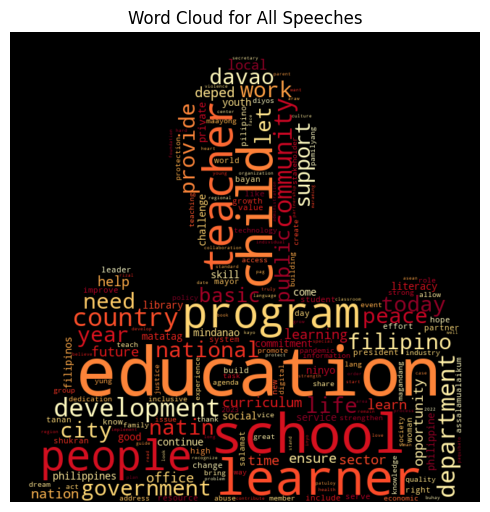

In [102]:
image = img.imread("data/mask.jpg")
wc = WordCloud(max_words=200, mask=image, colormap="YlOrRd")
wc = wc.generate_from_frequencies(Counter(lemmas))

plt.figure(figsize=(5, 5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
plt.title("Word Cloud for All Speeches")
plt.show()

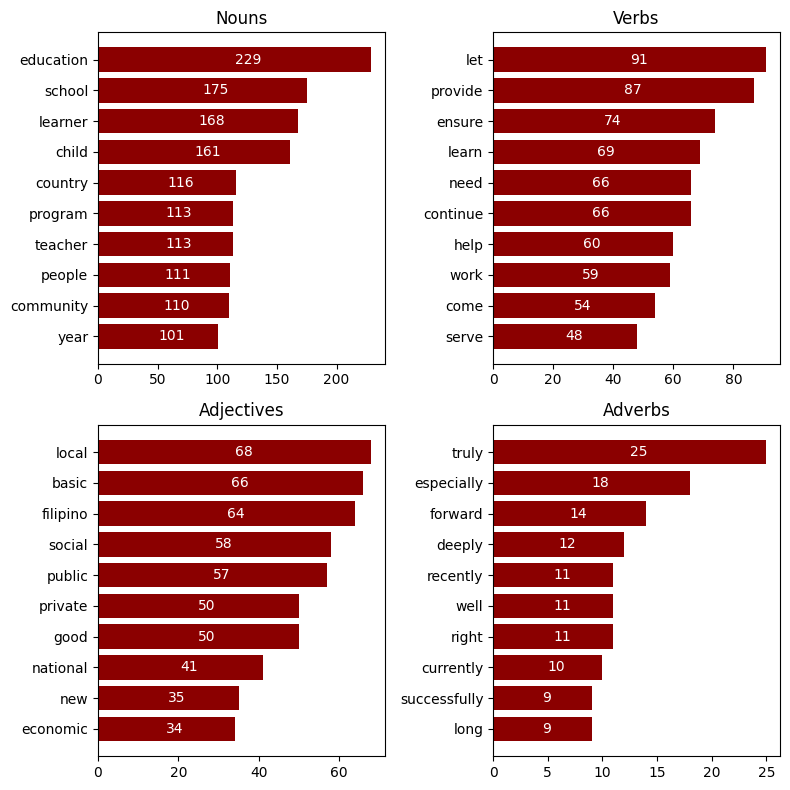

In [103]:
def plot_word_frequencies(words, ax, title):
    word_freq = Counter(words)
    words, frequencies = zip(*word_freq.most_common(10))
    ax.barh(words, frequencies, color="darkred")
    ax.set_title(title)
    ax.invert_yaxis()

    # Add value labels to each bar
    for index, value in enumerate(frequencies):
        ax.text(
            value - value / 2,
            index,
            str(value),
            color="white",
            va="center",
        )


nouns = [token.lemma_.lower() for token in tokens if token.pos_ == "NOUN"]
verbs = [token.lemma_.lower() for token in tokens if token.pos_ == "VERB"]
adjectives = [token.lemma_.lower() for token in tokens if token.pos_ == "ADJ"]
adverbs = [token.lemma_.lower() for token in tokens if token.pos_ == "ADV"]

fig, axs = plt.subplots(2, 2, figsize=(8, 8))

plot_word_frequencies(nouns, axs[0, 0], "Nouns")
plot_word_frequencies(verbs, axs[0, 1], "Verbs")
plot_word_frequencies(adjectives, axs[1, 0], "Adjectives")
plot_word_frequencies(adverbs, axs[1, 1], "Adverbs")

plt.tight_layout()
plt.show()

## Named entity recognition

In [104]:
df_orgs = pd.read_csv("data/organizations.csv")
df_orgs.head()

,Name,Acronym
0,Abra State Institute of Science and Technology,NaN
1,Advanced Science and Technology Institute,ASTI
2,Agricultural Credit Policy Council,ACPC
3,Agusan Del Sur State College of Agriculture an...,NaN
4,Aklan State University,NaN


In [105]:
ner_nlp = spacy.blank("en")
ruler = ner_nlp.add_pipe("entity_ruler")

# TODO: Add more patterns for relevant entities (e.g., programs, persons, etc.)
patterns = [
    {"label": "LEGISLATION", "pattern": [{"LOWER": "ra"}, {"SHAPE": "dddd"}]},
]

orgs = df_orgs.Name.tolist() + df_orgs.Acronym.tolist()
for org in orgs:
    patterns.append({"label": "ORG", "pattern": org})

with open("data/persons.txt", "r") as f:
    persons = f.read().splitlines()

for person in persons:
    patterns.append({"label": "PERSON", "pattern": person})

ruler.add_patterns(patterns)

In [106]:
entities = []
for speech in df.content:
    doc = ner_nlp(speech)
    entities.extend([ent.text for ent in doc.ents])

Counter(entities).most_common(20)

[('Department of Education', 78),
 ('DepEd', 74),
 ('Office of the Vice President', 20),
 ('Public Attorney’s Office', 8),
 ('Armed Forces of the Philippines', 6),
 ('Philippine National Police', 5),
 ('Ferdinand Marcos', 5),
 ('Mindanao Development Authority', 5),
 ('Department of Budget and Management', 4),
 ('DBM', 4),
 ('Bongbong Marcos', 4),
 ('Department of Health', 4),
 ('Philippine Navy', 4),
 ('Sara Duterte', 3),
 ('National Library of the Philippines', 3),
 ('DILG', 2),
 ('Rodrigo Duterte', 2),
 ('BIR', 1),
 ('RA 11708', 1),
 ('Philippine Normal University', 1)]